### Convert dataset to numeric representation

In [139]:
# %%capture thiscell
# #hide output of this cell
# %run ./feature_extraction.ipynb

In [140]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Convert features and corresponding classification labels into numpy arrays
X = np.array(MFCC_df.MFCC.tolist())
y = np.array(MFCC_df.class_label.tolist())
%store X
%store y
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))
# yy is one-hot encoding of label
%store yy
print(X.shape)
print(yy.shape)

Stored 'X' (ndarray)
Stored 'y' (ndarray)
Stored 'yy' (ndarray)
(1618, 40)
(1618, 29)


### Stratify dataset
Stratifying dataset can make each class distributed evenly

In [141]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

### Apply different models

- Multilayer Perceptron (MLP) Neural Network

The model has three dense layer:
1. Input layer has 40 nodes because our dataset shape of each instance is 1x40
2. One hidden layer including 256 nodes
3. Output layer including 29 nodes because we have 29 categories

- Model construction

In [142]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

num_labels = yy.shape[1]
filter_size = 2
# Construct model
model = Sequential()
model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

- Model compiling

In [143]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# Display model architecture summary
model.summary()
# Calculate pre-training accuracy
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]
print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               10496     
                                                                 
 activation_12 (Activation)  (None, 256)               0         
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 activation_13 (Activation)  (None, 256)               0         
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 29)               

- Model training

In [144]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
num_epochs = 100
num_batch_size = 32
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5',
verbose=1, save_best_only=True)
start = datetime.now()
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test,y_test))
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
41/41 [==============================] - 0s 3ms/step - loss: 29.7038 - accuracy: 0.0479 - val_loss: 3.3680 - val_accuracy: 0.0802
Epoch 2/100
41/41 [==============================] - 0s 2ms/step - loss: 9.5044 - accuracy: 0.0626 - val_loss: 3.2366 - val_accuracy: 0.0710
Epoch 3/100
41/41 [==============================] - 0s 2ms/step - loss: 4.7900 - accuracy: 0.0881 - val_loss: 3.3157 - val_accuracy: 0.1235
Epoch 4/100
41/41 [==============================] - 0s 2ms/step - loss: 3.9221 - accuracy: 0.0873 - val_loss: 3.3108 - val_accuracy: 0.1019
Epoch 5/100
41/41 [==============================] - 0s 3ms/step - loss: 3.5637 - accuracy: 0.0958 - val_loss: 3.3030 - val_accuracy: 0.1204
Epoch 6/100
41/41 [==============================] - 0s 2ms/step - loss: 3.4767 - accuracy: 0.1028 - val_loss: 3.2655 - val_accuracy: 0.1142
Epoch 7/100
41/41 [==============================] - 0s 2ms/step - loss: 3.3671 - accuracy: 0.1043 - val_loss: 3.2138 - val_accuracy: 0.1636
Epoch 8/100


In [145]:
%%capture thiscell
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

y_cat={}
y_num=[]
new_y=list(set(y))
enu_y=list(enumerate(new_y))
for count, item in enu_y:
    y_cat[item]=count
for y_item in y:
    y_num.append(y_cat[y_item])

n_classes = len(set(y))
Y = label_binarize(y_num, classes=[*range(n_classes)])
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    random_state = 42)

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test,y_test))
y_score = model.predict(X_test)


### PR curve

Text(0.5, 1.0, 'precision vs. recall curve')

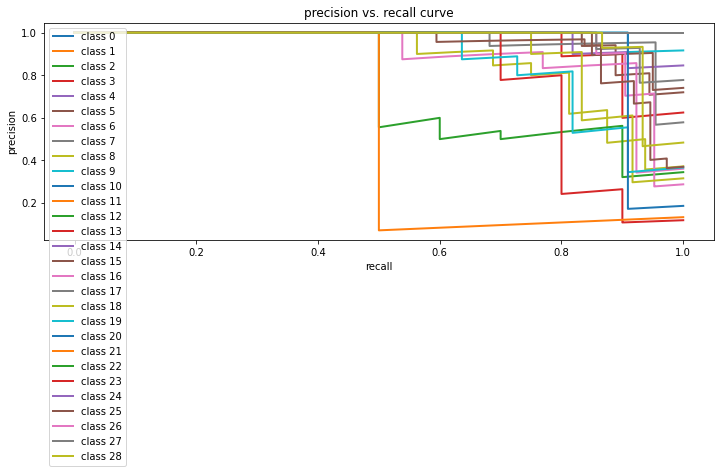

In [146]:
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

#plt.rcParams["figure.figsize"] = (12,4)
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")

### ROC curve

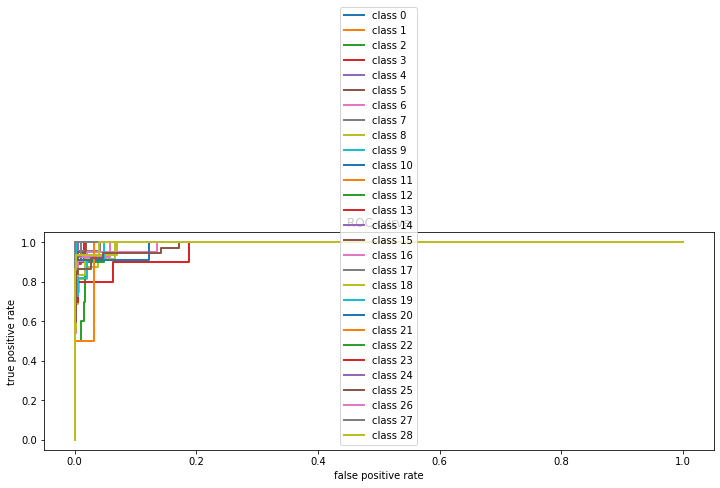

In [147]:
# roc curve
fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_score[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

#plt.rcParams["figure.figsize"] = (12,4)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()